## Graph Convolution GRU
Standard GRU cell with Chebyshev graph convolution. <br />

### GConvGRU

100%|██████████| 200/200 [16:26<00:00,  4.93s/it]


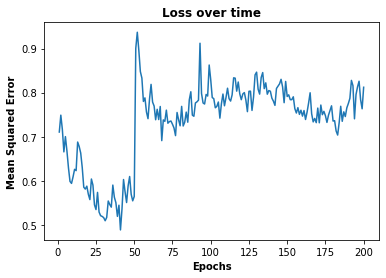

Train MSE: 0.8122
Test MSE: 0.8772


In [11]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric_temporal.nn.recurrent import GConvGRU

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 200

dataset = loader.get_dataset(lags)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

### MODEL DEFINITION
class RecurrentGCN(nn.Module):
    def __init__(self, node_features, window_length):
        super(RecurrentGCN, self).__init__()
        
        self.node_features = node_features
        self.n = window_length
        self.hidden_state_size = 64
        assert self.hidden_state_size % 2 == 0
                
        self.recurrent = GConvGRU(1, self.hidden_state_size, 2)
        self.linear1 = nn.Sequential(
            nn.Linear(self.hidden_state_size, self.hidden_state_size//2), 
            nn.Dropout(p=0.2),
            nn.ReLU()
        )
        self.out = nn.Sequential(
            nn.Linear(self.hidden_state_size//2, 1),
            nn.Flatten(start_dim=0, end_dim=-1)
        )

    def forward(self, window, c):        
        edge_index = window.edge_index
        edge_weight = None

        C = []
        for t in range(self.n):
            x = window.x[:,t].unsqueeze(0).T
            c = self.recurrent(x, edge_index, edge_weight, c)
            
            C.append(c.detach())
            
        x = self.linear1(c)
        pred = self.out(x)

        return pred, C
    
model = RecurrentGCN(node_features=1, window_length=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


### TRAIN
model.train()

loss_history = []
for _ in tqdm(range(epochs)):
    total_loss = 0
    c = None
    for i, window in enumerate(train_dataset):
        optimizer.zero_grad()
        
        y_pred, C = model(window, c)
        c = C[stride-1]

        assert y_pred.shape == window.y.shape
        loss = torch.mean((y_pred - window.y)**2)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= i+1
    loss_history.append(total_loss)

### TEST 
model.eval()
loss = 0
with torch.no_grad():
    c = None
    for i, window in enumerate(test_dataset):
        y_pred, C = model(window, c)
        c = C[stride-1]
        
        assert y_pred.shape == window.y.shape
        loss += torch.mean((y_pred - window.y)**2)
    loss /= i+1

### RESULTS PLOT
fig, ax = plt.subplots()

x_ticks = np.arange(1, epochs+1)
ax.plot(x_ticks, loss_history)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
plt.show()
    
print("Train MSE: {:.4f}".format(total_loss))
print("Test MSE: {:.4f}".format(loss))